In [1]:
import os
try:
    from google.colab import drive
    drive.mount('/content/drive/', force_remount=False)
    rootpath = '/content/drive/My Drive/ai-side-projects/contrastive_learning_mnist/'
except:
    rootpath = './'
os.chdir(rootpath)

In [2]:
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np

import torch
import torch.nn as nn

from src import get_mnist_dataloaders, classic_train, original_transform, torchvision

LOAD_MODELS = True


%matplotlib inline

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)
if device=='cuda':
    print(torch.cuda.get_device_properties(0).name)


cpu


In [3]:
batch_size = 64

trainloader, testloader, _ = get_mnist_dataloaders(batch_size=batch_size, dataset_size=1.0)


# trainset = torchvision.datasets.MNIST(root='./data', train=True,
#                                         download=True, transform=original_transform)
# trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
#                                           shuffle=True)

# testset = torchvision.datasets.MNIST(root='./data', train=False,
#                                        download=True, transform=original_transform)
# testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
#                                          shuffle=False)



Train size: 42000
Validation size: 12000
Test size: 6000


In [4]:
class ClassifierCNN(nn.Module):
    def __init__(self):
        super(ClassifierCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 8, 2, 2) #28x28 -> 14x14
        self.conv2 = nn.Conv2d(8, 16, 3, 3) #14x14 -> 4x4

        self.fc1 = nn.Linear(16*4*4, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 10)

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = torch.relu(self.conv2(x))

        x = nn.Flatten()(x)

        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

model = ClassifierCNN()

def test_shapes():
    model = ClassifierCNN()

    x = torch.randn(1, 1, 28, 28)
    y = model(x)


    print(f"""
        RESULT
    input shape: {x.shape}
    output shape: {y.shape}
        """)
    
test_shapes()


        RESULT
    input shape: torch.Size([1, 1, 28, 28])
    output shape: torch.Size([1, 10])
        


In [5]:
# tmp_model = ClassifierCNN()

# tmp_b = next(iter(dataloader_train))
# image_example = tmp_b[0][0].unsqueeze(0)
# label_example = tmp_b[1][0].unsqueeze(0)
# tmp_y = tmp_model(image_example)

# #print(nn.CrossEntropyLoss()(tmp_y, label_example).item())
# #print(nn.NLLLoss()(nn.LogSoftmax()(tmp_y), label_example).item())

In [6]:

lr = 1e-3

model = ClassifierCNN().to(device)

if LOAD_MODELS:
    try:
        #vae.load_state_dict(torch.load('./models/vae'))
        if device == 'cuda':
            model.load_state_dict(torch.load('models/classifier'))
        if device == 'cpu':
            model.load_state_dict(torch.load('models/classifier', map_location=torch.device('cpu')))
        history = pd.read_csv('models/classifier_history.csv')
        #history to dict
        history = history.to_dict(orient='list')
        print('Model loaded')

    except:
        print('Could not load model')
        history = None
        pass



criterion = nn.CrossEntropyLoss()
#optimizer = torch.optim.Adam(model.parameters(), lr=lr)
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
#scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)



Could not load model


In [7]:
#number of parameters
print(sum(p.numel() for p in ClassifierCNN().parameters()))

20066


In [10]:
n_epochs = 4

history = classic_train(model, criterion, optimizer, scheduler=None,
                           dataloader_train=trainloader, dataloader_val=testloader,
                           history=history,
                           epochs=n_epochs,
                           device=device)


Epochs: 100%|██████████| 4/4 [00:27<00:00,  6.97s/it, Loss=0.27647, Val Loss=0.26244]

Model and history saved


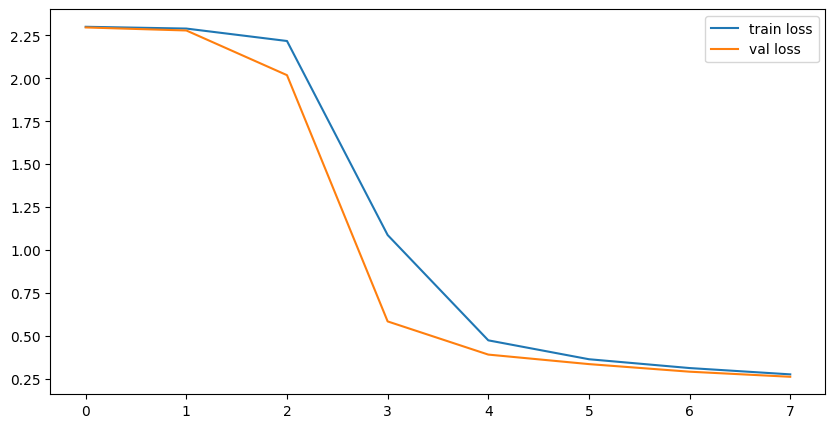

In [11]:
plt.figure(figsize=(10, 5))
plt.plot(history['train_loss'], label='train loss')
plt.plot(history['val_loss'], label='val loss')
plt.legend()